In [1]:
%matplotlib inline

In [2]:
# from __future__ import print_function
import time
import cv2
from OpticalFlowShowcase import *
import numpy as np
import argparse
import io
import sys
import datetime
from matplotlib import pyplot as plt
from matplotlib import animation
import matplotlib.gridspec as gridspec
from mpl_toolkits import mplot3d
from memory_profiler import profile
from uncertainties import unumpy
import uncertainties as u
import ucert

In [3]:
plt.rcParams['figure.figsize'] = [13, 9]

In [4]:
def process(file):
    numObj = np.load(file)
    [date, arr] = numObj
    return [date, arr]

In [5]:
def pythag(arr):
    # This is going to reduce the system into one array ~ ideally ~ a mxm matrix of rank 2
    finalArr = np.zeros(arr.shape[:-1],dtype='float32')
    for i in range(arr.shape[-1]):
        finalArr += np.power(arr[...,i], 2)
    return np.power(finalArr, 0.5)

In [6]:
def edge(arr, scope):
    if len(scope) == 2:
        lowerBound_x = lowerBound_y = scope[0]
        upperBound_x = upperBound_y = scope[1]
    elif len(scope) == 4:
        lowerBound_x = scope[0]; lowerBound_y = scope[2]
        upperBound_x = scope[1]; upperBound_y = scope[3]
    else: return None
    x_ = arr.shape[0]; y_ = arr.shape[1]
    return arr[int(x_*lowerBound_x):int(x_*upperBound_x),int(y_*lowerBound_y):int(y_*upperBound_y),:]

In [7]:
def gradient(array): return np.gradient(array) #np.add.reduce(np.gradient(array))

In [8]:
def importMatrix(file):
    num_cols = 2
    converters = dict.fromkeys(
        range(num_cols),
        lambda col_bytes: u.ufloat_fromstr(col_bytes.decode("latin1")))
    arr = np.loadtxt(file, converters=converters, dtype=object)
    return arr.reshape((64,64,2))

In [9]:
# Shouldn't really be needed
def normalize(x):
    return x/np.amax(np.absolute(x))

In [10]:
def intensity(x):
    # This is taking the hypotenuse of the intensity vectors
    assert type(x).__module__ == np.__name__
    return np.power(np.sum(np.power(x,2),axis=len(x.shape)-1),0.5) # pythagorean

In [11]:
A = np.load('aw_motion_wk7.npy')

In [12]:
A = edge(A, (0.2, 0.74))

This function is looking to take something with an X and Y system to decompose it into a collapsed major system

In [13]:
# A = pythag(A)

In [14]:
print(A.shape)x

(35, 35, 2)


This function yields the gradient (velocities at each given point within the graph - it's in experimental mode at the moment and prone to failure as it changes the dimensions of the matrix)

In [15]:
# A = gradient(A[...,0])

This code block underneath will normalize any matrix, showing relative weight between the matrices

In [16]:
print(A.shape)

(35, 35, 2)


In [17]:
A = normalize(A)

In [18]:
def floaty(*args):
    ret = []
    for i in args:
        if type(i) is np.ndarray: 
            ret.append(i.astype('float64'))
        else:
            raise ValueError
    return ret

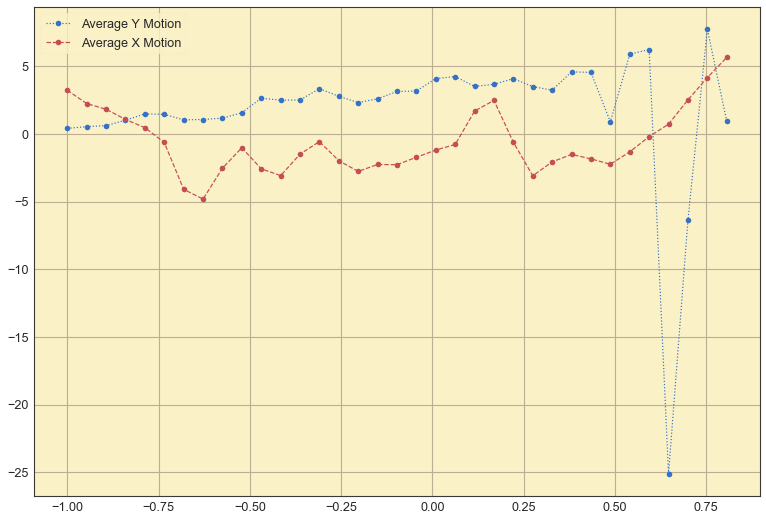

In [25]:
import matplotlib.pyplot as plt
X = np.linspace(np.min(A),np.max(A),num=A.shape[0])
y_motion = A[...,1]; x_motion = A[...,0];
y_avg = np.sum(y_motion, axis=1)
x_avg = np.sum(x_motion, axis=0)
max_val = np.max(y_motion.shape); min_val = 0
content = [X, y_avg, x_avg]
[X, y_avg, x_avg] = floaty(*content)
plt.plot(X,y_avg,'bo:', label="Average Y Motion")
plt.plot(X,x_avg,'ro--', label="Average X Motion")
plt.legend(loc='best')
plt.show()

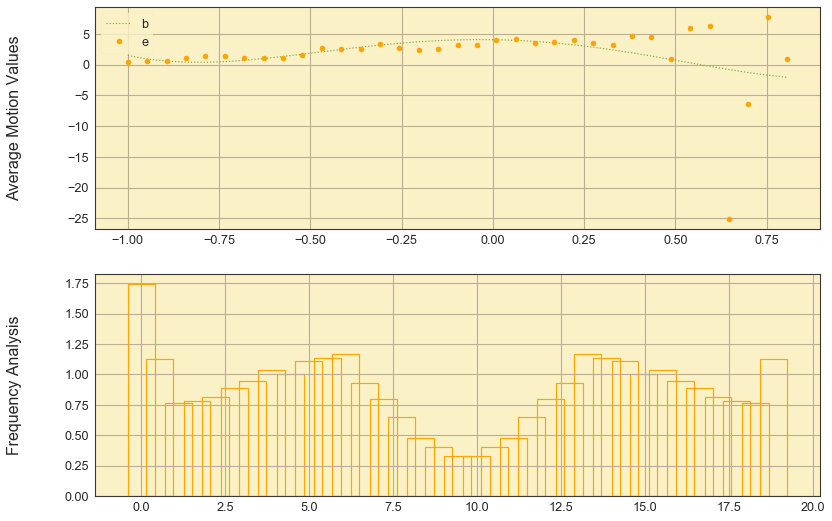

In [26]:
gs = gridspec.GridSpec(2,1, hspace=0.2)
fig = plt.figure()

direction = y_avg
V = np.polyfit(X,direction,4)
Y = np.poly1d(V)
N = direction.size;
t = X[1]-X[0];
f = np.linspace(0,1/t,N);
fft = np.fft.fft(direction);

#first plot
ax = fig.add_subplot(gs[0])
ax.plot(X,Y(X),"g:", label='Polyfit Terms')
ax.plot(X,y_avg,'o',color='orange', label="Average Motion Terms")
ax.set_ylabel(r'Average Motion Values', size =16)
ax.get_yaxis().set_label_coords(-0.1,0.5)
ax.legend('best')

#second plot
ax = fig.add_subplot(gs[1])
ax.bar(f[:N], np.abs(fft)[:N] * (1 / N), color="#516c32", fill=False, edgecolor="orange", linewidth=1.2)
ax.set_ylabel(r'Frequency Analysis', size =16)
ax.get_yaxis().set_label_coords(-0.1,0.5)

plt.show()

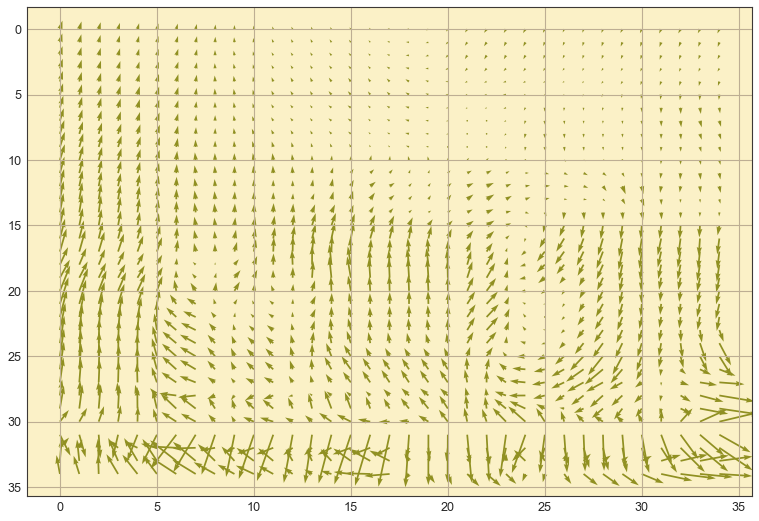

In [45]:
heat_x = np.linspace(np.min(A[0,...]), np.max(A[0,...]), num=A.shape[0])
heat_y = np.linspace(np.min(A[1,...]), np.max(A[1,...]), num=A.shape[1])
XX,YY = np.meshgrid(heat_x,heat_y)
plt.quiver(A[...,0],A[...,1], color='#909022')
plt.gca().invert_yaxis()
#plt.contourf(YY, XX, A[...,0], 20, cmap='coolwarm');
#plt.colorbar();
plt.show()

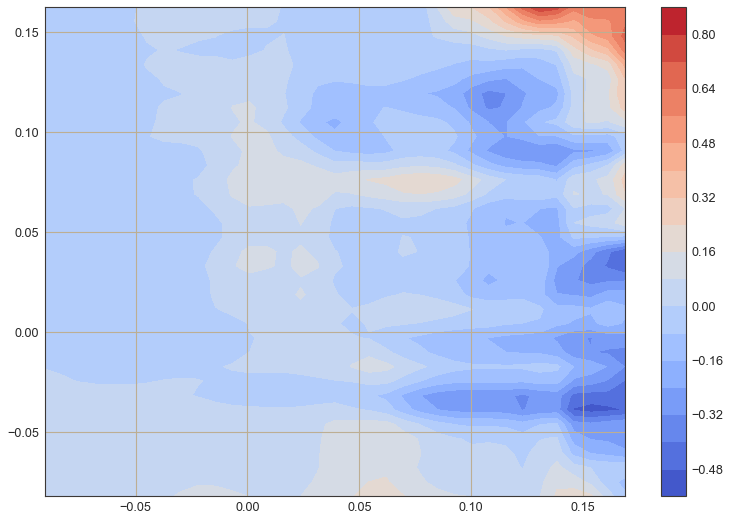

In [46]:
plt.contourf(YY, XX, A[...,0], 20, cmap='coolwarm');
plt.colorbar();